In [2]:
import pandas as pd
import numpy as np
import gzip
import os
import glob
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [12]:
# Define paths
data_dir = '../data/raw/isd_data'
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

# Load station metadata
stations_df = pd.read_csv('../data/processed/selected_stations.csv')
print(f"Loaded metadata for {len(stations_df)} stations")
display(stations_df[['STATION_ID', 'STATION NAME', 'CITY']])

Loaded metadata for 8 stations


,STATION_ID,STATION NAME,CITY
0,744860-94789,JOHN F KENNEDY INTERNATIONAL AIRPORT,New York City
1,722950-23174,LOS ANGELES INTERNATIONAL AIRPORT,Los Angeles
2,725300-94846,CHICAGO O'HARE INTERNATIONAL AIRPORT,Chicago
3,722020-12839,MIAMI INTERNATIONAL AIRPORT,Miami
4,722430-12960,G BUSH INTERCONTINENTAL AP/HOUSTON AP,Houston
5,994971-99999,BOSTON,Boston
6,726580-14922,MINNEAPOLIS-ST PAUL INTERNATIONAL AP,Minneapolis
7,727930-24233,SEATTLE-TACOMA INTERNATIONAL AIRPORT,Seattle


In [13]:
# Create a mapping from station ID to city name
station_to_city = dict(zip(stations_df['STATION_ID'], stations_df['CITY']))

In [14]:
# Define the ISD parser
def parse_isd_file(filepath):
    """Parse a NOAA ISD file in the fixed-width format"""
    # List to store parsed records
    records = []
    
    # Station ID from filename
    filename = os.path.basename(filepath)
    station_id = '-'.join(filename.split('-')[:2])  # Extract just the station part
    
    # Get the city for this station
    city = station_to_city.get(station_id, "Unknown")
    
    # Open the gzipped file
    with gzip.open(filepath, 'rt', encoding='utf-8', errors='replace') as f:
        for line in f:
            try:
                # Parse the mandatory fixed section
                record = {
                    'usaf': line[4:10],
                    'wban': line[10:15],
                    'date': line[15:23],  # YYYYMMDD
                    'time': line[23:27],  # HHMM
                    'latitude': line[28:34] if line[28:34].strip() else None,  # Decimal degrees
                    'longitude': line[34:41] if line[34:41].strip() else None,  # Decimal degrees
                    'elevation': line[46:51] if line[46:51].strip() else None,  # Meters
                    'wind_direction': line[60:63] if line[60:63].strip() else None,  # Degrees
                    'wind_speed': line[65:69] if line[65:69].strip() else None,  # Meters/Second * 10
                    'temperature': line[87:92] if line[87:92].strip() else None,  # Celsius * 10
                    'dew_point': line[93:98] if line[93:98].strip() else None,  # Celsius * 10
                    'air_pressure': line[99:104] if line[99:104].strip() else None,  # Hectopascals * 10
                }
                
                # Parse the timestamp
                try:
                    year = int(record['date'][:4])
                    month = int(record['date'][4:6])
                    day = int(record['date'][6:8])
                    hour = int(record['time'][:2])
                    minute = int(record['time'][2:])
                    
                    record['timestamp'] = datetime(year, month, day, hour, minute).isoformat()
                except ValueError:
                    record['timestamp'] = None
                
                # Convert numeric fields and scale appropriately
                for field in ['latitude', 'longitude', 'elevation']:
                    if record[field] is not None and record[field].strip():
                        try:
                            record[field] = float(record[field])
                        except ValueError:
                            record[field] = None
                
                # These fields are scaled by 10 in the data
                for field in ['wind_speed', 'temperature', 'dew_point', 'air_pressure']:
                    if record[field] is not None and record[field].strip():
                        try:
                            record[field] = float(record[field]) / 10.0
                        except ValueError:
                            record[field] = None
                
                # Wind direction is integer degrees
                if record['wind_direction'] is not None and record['wind_direction'].strip():
                    try:
                        record['wind_direction'] = int(record['wind_direction'])
                    except ValueError:
                        record['wind_direction'] = None
                
                # Parse precipitation data which is in variable-length section
                # Look for AA1-AA4 patterns which indicate precipitation data
                precipitation = None
                for pattern in ['AA1', 'AA2', 'AA3', 'AA4']:
                    if pattern in line:
                        aa_pos = line.find(pattern)
                        if aa_pos != -1 and len(line) >= aa_pos + 8:
                            precip_data = line[aa_pos+3:aa_pos+7]
                            if precip_data.strip():
                                try:
                                    precipitation = float(precip_data) / 10.0  # mm
                                    break  # Use the first valid precipitation data found
                                except ValueError:
                                    pass
                
                record['precipitation'] = precipitation
                
                # Add city information
                record['city'] = city
                
                # Skip records with missing essential data
                if record['timestamp'] is None or record['temperature'] is None:
                    continue
                    
                records.append(record)
                
            except Exception as e:
                # Skip problematic lines
                continue
    
    # Convert to DataFrame
    if records:
        df = pd.DataFrame(records)
        return df
    else:
        # Return empty DataFrame with correct columns if no valid records
        return pd.DataFrame(columns=['usaf', 'wban', 'date', 'time', 'latitude', 'longitude', 
                                    'elevation', 'wind_direction', 'wind_speed', 'temperature', 
                                    'dew_point', 'air_pressure', 'timestamp', 'precipitation', 'city'])


In [15]:
# Get list of files to process
files = glob.glob(os.path.join(data_dir, '*.gz'))
print(f"Found {len(files)} files to process")

Found 48 files to process


In [16]:
# Process a sample file first to verify parser
if files:
    sample_file = files[0]
    print(f"Processing sample file: {os.path.basename(sample_file)}")
    sample_df = parse_isd_file(sample_file)
    print(f"Sample file contains {len(sample_df)} records")
    if not sample_df.empty:
        display(sample_df.head())
        
        # Check data types and missing values
        print("\nData types:")
        display(sample_df.dtypes)
        
        print("\nMissing values (first 10 columns):")
        display(sample_df.iloc[:, :10].isnull().sum())
    else:
        print("Sample file parsing produced no valid records. Please check the parser.")


Processing sample file: 725300-94846-2020.gz
Sample file contains 12721 records


,usaf,wban,date,time,latitude,longitude,elevation,wind_direction,wind_speed,temperature,dew_point,air_pressure,timestamp,precipitation,city
0,725300,94846,20200101,0000,41983.0,-87900.0,205.0,260,6.2,-2.2,-6.1,1009.8,2020-01-01T00:00:00,NaN,Chicago
1,725300,94846,20200101,0051,41960.0,-87932.0,205.0,260,6.7,-2.2,-6.1,1010.0,2020-01-01T00:51:00,10.0,Chicago
2,725300,94846,20200101,0151,41960.0,-87932.0,205.0,260,6.7,-2.2,-6.1,1010.2,2020-01-01T01:51:00,10.0,Chicago
3,725300,94846,20200101,0205,41960.0,-87932.0,205.0,260,4.6,-2.8,-6.1,9999.9,2020-01-01T02:05:00,NaN,Chicago
4,725300,94846,20200101,0251,41960.0,-87932.0,205.0,250,5.1,-2.8,-6.1,1010.1,2020-01-01T02:51:00,10.0,Chicago



Data types:


usaf               object
wban               object
date               object
time               object
latitude          float64
longitude         float64
elevation         float64
wind_direction      int64
wind_speed        float64
temperature       float64
dew_point         float64
air_pressure      float64
timestamp          object
precipitation     float64
city               object
dtype: object


Missing values (first 10 columns):


usaf              0
wban              0
date              0
time              0
latitude          0
longitude         0
elevation         0
wind_direction    0
wind_speed        0
temperature       0
dtype: int64

In [19]:
df.head()

,usaf,wban,date,time,latitude,longitude,elevation,wind_direction,wind_speed,temperature,dew_point,air_pressure,timestamp,precipitation,city
0,744860,94789,20210101,0000,40650.0,-73783.0,7.0,320,6.2,5.0,-2.8,1026.1,2021-01-01T00:00:00,NaN,New York City
1,744860,94789,20210101,0051,40639.0,-73764.0,7.0,320,6.7,4.4,-3.3,1027.4,2021-01-01T00:51:00,10.0,New York City
2,744860,94789,20210101,0151,40639.0,-73764.0,7.0,350,4.6,3.9,-4.4,1027.8,2021-01-01T01:51:00,10.0,New York City
3,744860,94789,20210101,0251,40639.0,-73764.0,7.0,340,3.6,2.2,-4.4,1028.8,2021-01-01T02:51:00,10.0,New York City
4,744860,94789,20210101,0300,40650.0,-73783.0,7.0,340,3.6,2.2,-4.4,1028.8,2021-01-01T03:00:00,NaN,New York City


Processing files:   0%|          | 0/48 [00:00<?, ?it/s]


Processing summary:
- Successfully processed: 48 files
- Empty files (no valid records): 0 files
- Processing errors: 0 files
Combined data has 693541 rows and 15 columns
After removing duplicates: 689715 rows
After removing rows with missing data: 689715 rows
Saved processed data to ../data/processed/hourly_weather_data.csv


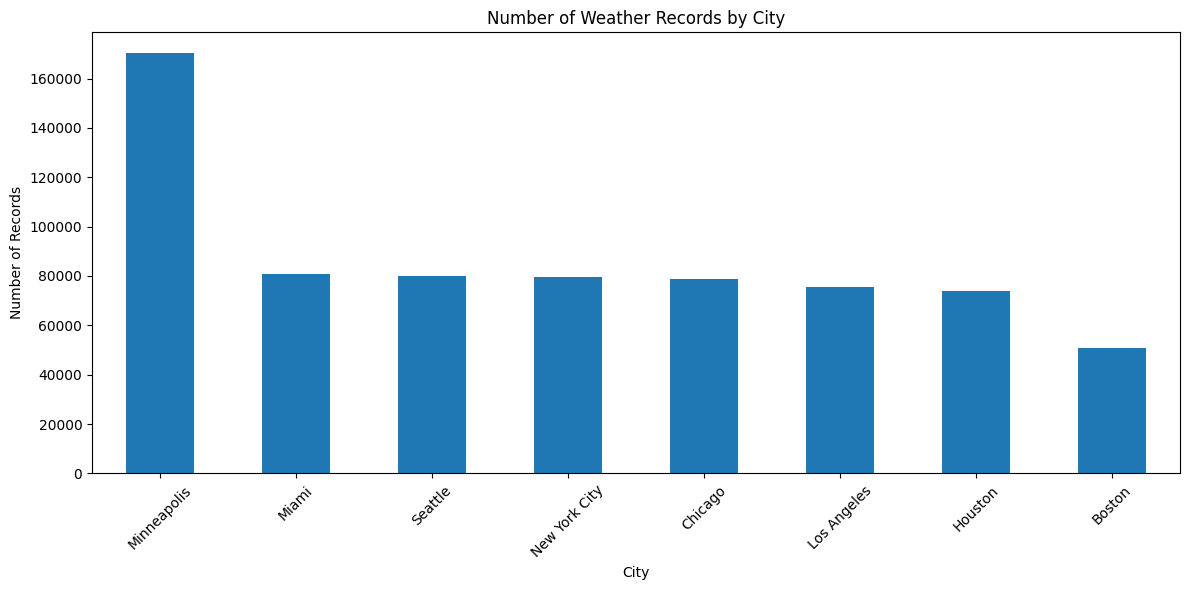

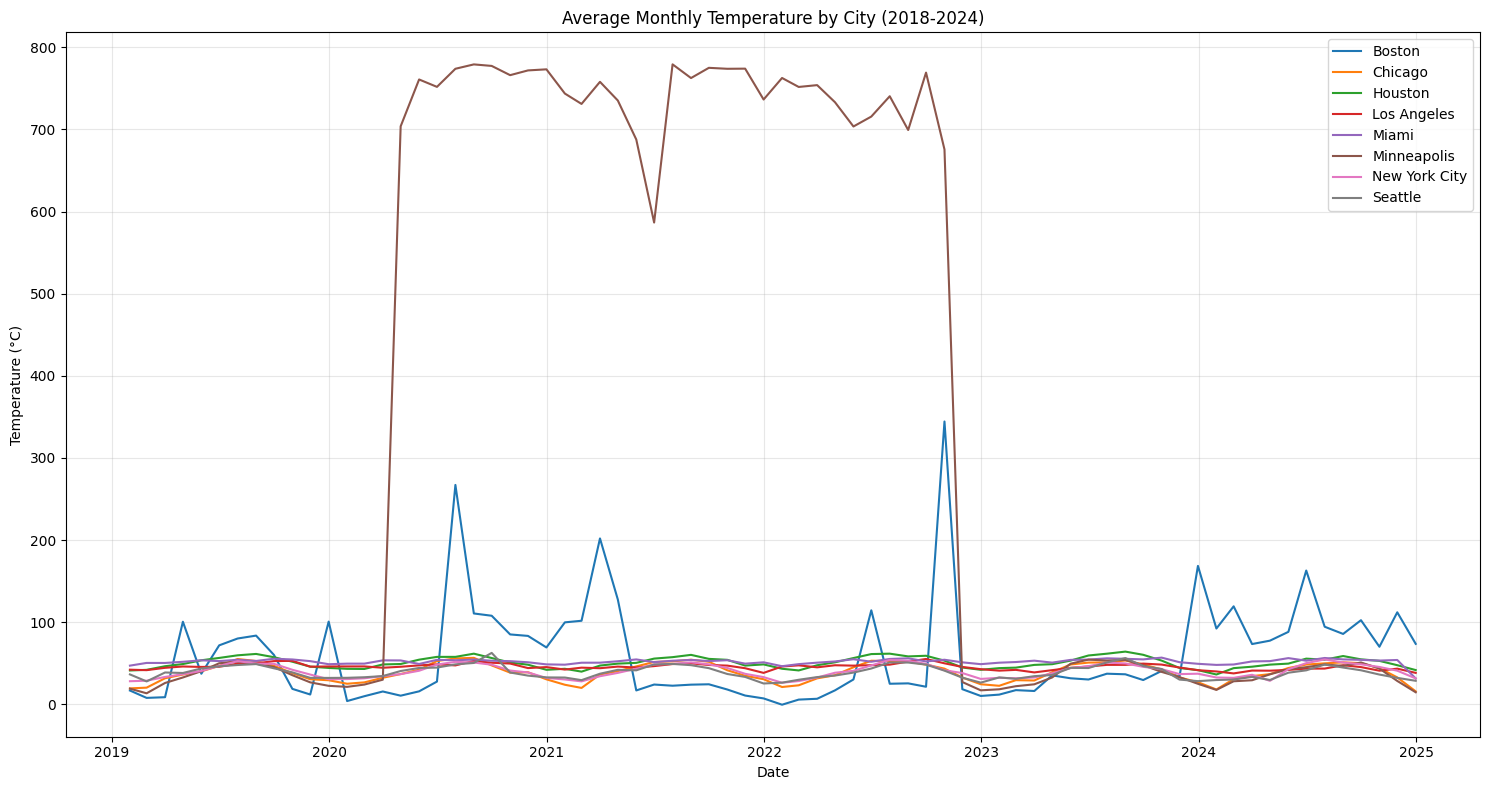

Saved summary statistics to ../data/processed/weather_summary_by_city.csv


,avg_temp_c,min_temp_c,max_temp_c,temp_std_c,avg_precip_mm,total_precip_mm,pct_days_with_rain,avg_wind_speed_m_s,max_wind_speed_m_s
city,,,,,,,,,
Boston,59.302814,-22.4,999.9,210.362365,NaN,0.0,0.000000,469.513282,999.9
Chicago,38.377674,-30.6,999.9,162.774982,20.752593,1320404.5,80.698595,31.987648,999.9
Houston,50.735541,-10.6,999.9,166.320546,21.303759,1271237.9,80.888154,33.178149,999.9
Los Angeles,45.549512,4.4,999.9,165.213817,19.944572,1121722.6,74.479891,32.496836,999.9
Miami,52.099107,4.4,999.9,157.829652,22.210459,1382068.0,76.896270,30.845599,999.9
Minneapolis,551.966805,-33.3,999.9,493.529203,20.563867,1312200.9,37.491334,550.174077,999.9
New York City,40.464782,-16.1,999.9,161.756859,21.710395,1318884.8,76.164744,32.456641,999.9
Seattle,38.442205,-9.4,999.9,162.155539,21.580829,1329033.8,76.920387,32.256520,999.9



Data range: 2019-01-01 to 2024-12-31 (2192 days)

Data completeness by city:
Boston: 2161/2192 days (98.6%)
Chicago: 2192/2192 days (100.0%)
Houston: 2192/2192 days (100.0%)
Los Angeles: 2192/2192 days (100.0%)
Miami: 2192/2192 days (100.0%)
Minneapolis: 2192/2192 days (100.0%)
New York City: 2192/2192 days (100.0%)
Seattle: 2192/2192 days (100.0%)


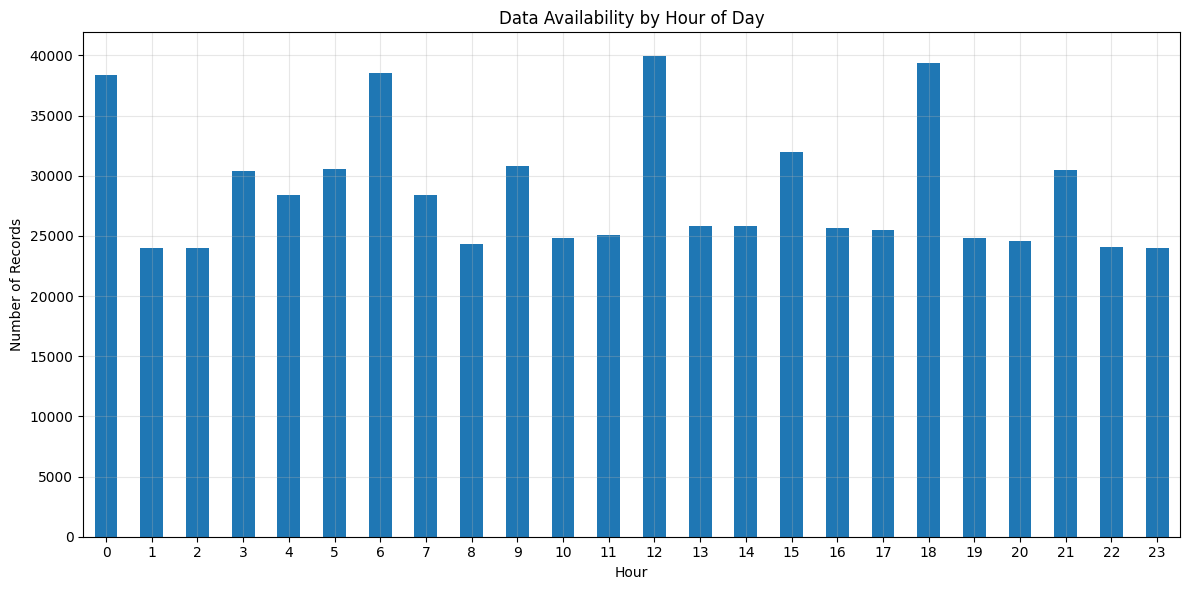

In [ ]:
# Ask if we should proceed with all files
proceed = input("Proceed with processing all files? (y/n): ")

if proceed.lower() != 'y':
    print("Processing stopped.")
else:
    # Process all files with progress bar
    all_data = []
    successful_files = 0
    empty_files = 0
    error_files = 0
    
    for filepath in tqdm(files, desc="Processing files"):
        try:
            df = parse_isd_file(filepath)
            if not df.empty:
                all_data.append(df)
                successful_files += 1
            else:
                empty_files += 1
                print(f"Warning: No valid records in {os.path.basename(filepath)}")
        except Exception as e:
            error_files += 1
            print(f"Error processing {os.path.basename(filepath)}: {str(e)}")
    
    print(f"\nProcessing summary:")
    print(f"- Successfully processed: {successful_files} files")
    print(f"- Empty files (no valid records): {empty_files} files")
    print(f"- Processing errors: {error_files} files")

    # Combine all data
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"Combined data has {combined_df.shape[0]} rows and {combined_df.shape[1]} columns")
        
        # Drop any duplicates
        combined_df = combined_df.drop_duplicates(subset=['usaf', 'wban', 'timestamp'])
        print(f"After removing duplicates: {combined_df.shape[0]} rows")
        
        # Clean the data
        # Remove any remaining rows with missing essential data
        combined_df = combined_df.dropna(subset=['timestamp', 'temperature', 'city'])
        print(f"After removing rows with missing data: {combined_df.shape[0]} rows")
        
        # Convert timestamp to datetime for easier filtering and analysis
        combined_df['datetime'] = pd.to_datetime(combined_df['timestamp'])
        
        # Add date and hour columns
        combined_df['date'] = combined_df['datetime'].dt.date
        combined_df['hour'] = combined_df['datetime'].dt.hour
        
        # Sort by city and timestamp
        combined_df = combined_df.sort_values(['city', 'datetime'])
        
        # Save to CSV
        output_path = os.path.join(output_dir, 'hourly_weather_data.csv')
        combined_df.to_csv(output_path, index=False)
        print(f"Saved processed data to {output_path}")
        
        # Basic visualization
        # 1. Data availability by city
        city_counts = combined_df['city'].value_counts()
        
        plt.figure(figsize=(12, 6))
        city_counts.plot(kind='bar')
        plt.title('Number of Weather Records by City')
        plt.xlabel('City')
        plt.ylabel('Number of Records')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'records_by_city.png'))
        plt.show()
        
        # 2. Temperature trends
        plt.figure(figsize=(15, 8))
        
        # Group by city and date, get average temperature
        temp_by_city_date = combined_df.groupby(['city', pd.Grouper(key='datetime', freq='M')])['temperature'].mean().reset_index()
        
        # Plot for each city
        for city in combined_df['city'].unique():
            city_data = temp_by_city_date[temp_by_city_date['city'] == city]
            plt.plot(city_data['datetime'], city_data['temperature'], label=city)
        
        plt.title('Average Monthly Temperature by City (2019-2024)')
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'temperature_trends.png'))
        plt.show()
        
        # 3. Summary statistics
        summary_stats = combined_df.groupby('city').agg({
            'temperature': ['mean', 'min', 'max', 'std'],
            'precipitation': ['mean', 'sum', lambda x: (x > 0).mean() * 100],  # % of days with precipitation
            'wind_speed': ['mean', 'max']
        })
        
        # Rename columns for clarity
        summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
        summary_stats = summary_stats.rename(columns={
            'temperature_mean': 'avg_temp_c',
            'temperature_min': 'min_temp_c',
            'temperature_max': 'max_temp_c',
            'temperature_std': 'temp_std_c',
            'precipitation_mean': 'avg_precip_mm',
            'precipitation_sum': 'total_precip_mm',
            'precipitation_<lambda_0>': 'pct_days_with_rain',
            'wind_speed_mean': 'avg_wind_speed_m_s',
            'wind_speed_max': 'max_wind_speed_m_s'
        })
        
        # Save summary stats
        summary_stats.to_csv(os.path.join(output_dir, 'weather_summary_by_city.csv'))
        print(f"Saved summary statistics to {os.path.join(output_dir, 'weather_summary_by_city.csv')}")
        
        # Display summary stats
        display(summary_stats)
        
        # 4. Data completeness check (days with data by city)
        # Get the date range in the data
        start_date = combined_df['datetime'].min().date()
        end_date = combined_df['datetime'].max().date()
        date_range = pd.date_range(start=start_date, end=end_date).date
        
        print(f"\nData range: {start_date} to {end_date} ({len(date_range)} days)")
        
        # Check days with data for each city
        print("\nData completeness by city:")
        for city in combined_df['city'].unique():
            city_data = combined_df[combined_df['city'] == city]
            city_dates = city_data['date'].unique()
            coverage = (len(city_dates) / len(date_range)) * 100
            print(f"{city}: {len(city_dates)}/{len(date_range)} days ({coverage:.1f}%)")
        
        # 5. Hourly data patterns
        plt.figure(figsize=(12, 6))
        hourly_counts = combined_df['hour'].value_counts().sort_index()
        hourly_counts.plot(kind='bar')
        plt.title('Data Availability by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('Number of Records')
        plt.xticks(rotation=0)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'records_by_hour.png'))
        plt.show()
    else:
        print("No data was successfully processed.")
